# **Deep Learning Homework 6: *Variational Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---

In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset. In developing the VAE we also explore how to develop an ad-hoc layer and a custom training step.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.


### Load Dataset
We load the MNIST dataset, using `tf.keras.datasets`. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits.

In [ ]:
# load necessary libriaries and functions
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch,history.history['reconstruction_loss'])
  plt.title('reconstruction_loss')
  plt.subplot(1, 2, 2)
  plt.plot(history.epoch,history.history['kl_loss'])
  plt.title('kl_loss')
  plt.show()

In [ ]:
(x_train_full, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the pixel values
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the arrays
x_train = x_train_full.reshape((len(x_train_full), np.prod(x_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# In this HW, we will not need a validation set since we will not deal with model selection
# x_valid, y_valid = x_train[:10000], y_train[:10000]
# x_train, y_train = x_train[10000:], y_train[10000:]

11501568/11490434 [==============================] - 0s 0us/step


##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class `tf.keras.layers` that is used as base class for all the layers defined in Keras. In more detail, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[TO COMPLETE]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method, and make sure the output shape is the proper one.


In [ ]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #[TO COMPLETE] compute and return z
        z_mean, z_var = inputs
        # ...
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean),mean=0.0,stddev=1.0)
        z = z_mean + tf.exp(z_var/2) * epsilon
        return z

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the Encoder. Let's use $n$ dense layers (similarly to what we did in HW5, with a funnel-like architecture), and then use the obtained encoding to compute `z_mean` and `z_var`, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model `z_mean` and `z_var`. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. Insert motivations about your choice into the tex cell below.

In [ ]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))
# x = ...[TO COMPLETE with more layers]...
x = tf.keras.layers.Dense(512, activation='elu')(encoder_inputs) #[TO COMPLETE]
x = tf.keras.layers.Dense(256, activation='elu')(x) #[TO COMPLETE]
x = tf.keras.layers.Dense(128, activation='elu')(x)
x = tf.keras.layers.Dense(64, activation='elu')(x)


z_mean =  tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 784)]        0           []                               
                                                                                                  
 dense_139 (Dense)              (None, 512)          401920      ['input_22[0][0]']               
                                                                                                  
 dense_140 (Dense)              (None, 256)          131328      ['dense_139[0][0]']              
                                                                                                  
 dense_141 (Dense)              (None, 128)          32896       ['dense_140[0][0]']              
                                                                                            

**Answer:** [TO COMPLETE]

After many tests, I end up with the above version of deep encoder made up by 4 layers whose number of parameters reduce by half. Regarding the activation function, I chose elu as activation function because among the ones I tried, that is sigmoid, tanh, gelu and relu, it gives me the best results. For the z\_mean and z\_var layers, I used a linear activation function in order to not change the values that tbey receive in input.

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. $n$ layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: Define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer). Answer in the text cell below.

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
#...[TO COMPLETE]...
x= tf.keras.layers.Dense(64,activation='elu')(latent_inputs)
x= tf.keras.layers.Dense(128,activation='elu')(x)
x= tf.keras.layers.Dense(256,activation='elu')(x)
x= tf.keras.layers.Dense(512,activation='elu')(x)
decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_145 (Dense)           (None, 64)                192       
                                                                 
 dense_146 (Dense)           (None, 128)               8320      
                                                                 
 dense_147 (Dense)           (None, 256)               33024     
                                                                 
 dense_148 (Dense)           (None, 512)               131584    
                                                                 
 dense_149 (Dense)           (None, 784)               402192    
                                                                 
Total params: 575,312
Trainable params: 575,312
Non-trainab

**Answer:** [TO COMPLETE]

Since the decoder architecture should be specular to the encoder one, I used exactly the same layers of the encoder with elu as activation function. What is notable, It's the fact that I used sigmoid for the last dense layer instead of another elu, because the reconstructed loss is computed exploiting binary\_crossentropy and it's useful to keep the value in $[0, 1]$.

##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy (`keras.losses.binary_crossentropy`) to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # record operations for automatic differentiation
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)
            INPUT_DIM = data.shape[-1]
            reconstruction_loss = INPUT_DIM * tf.reduce_mean(tf.keras.losses.binary_crossentropy(data,reconstruction))#[TO COMPLETE]

            kl_loss = -0.5 * tf.reduce_mean(1 + z_var - z_mean**2 - tf.exp(z_var))

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) # optimize the custom loss
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

Epoch 1/30
469/469 [==============================] - 3s 4ms/step - loss: 182.4305 - reconstruction_loss: 179.1441 - kl_loss: 3.2864
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 161.3858 - reconstruction_loss: 158.2122 - kl_loss: 3.1736
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 152.8767 - reconstruction_loss: 149.4730 - kl_loss: 3.4037
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 148.0626 - reconstruction_loss: 144.5531 - kl_loss: 3.5095
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 145.4457 - reconstruction_loss: 141.8073 - kl_loss: 3.6385
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 143.4300 - reconstruction_loss: 139.7614 - kl_loss: 3.6686
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 142.2902 - reconstruction_loss: 138.5819 - kl_loss: 3.7082
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - l

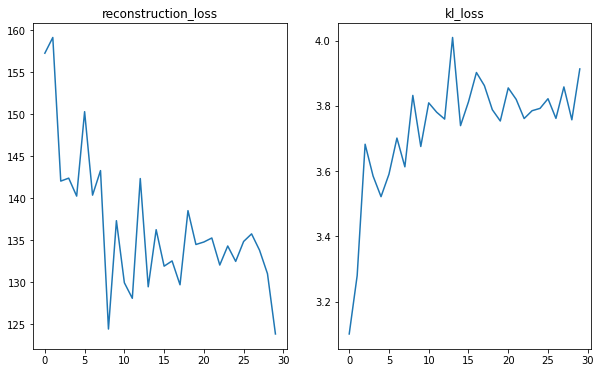

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)
plot_loss(history)

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

In [ ]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    print(f"Current scale: {scale}")
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

Current scale: 2.0


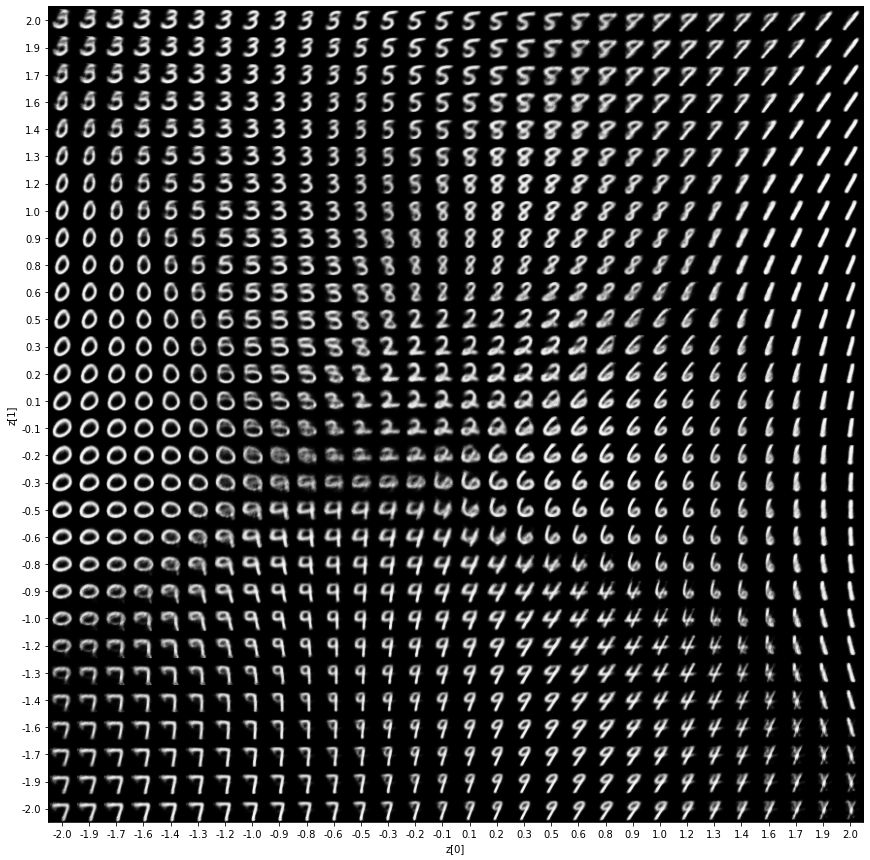

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) 

In [ ]:
scales = [-15, -10, -5, 0, 1, 5, 10, 15, 30]

for scale in scales:
  plot_latent(encoder, decoder, scale, 30) 

#[TO COMPLETE] explore what happens with different "scales"

Output hidden; open in https://colab.research.google.com to view.

The values for scale I tried are the following: $[-15, -10, -5, 0, 1, 5, 10, 15, 30]$. I noticed that with very high or low values, I obtained a latent space which is almost or totally incomprenshible, with values close to 0, I got decent digits and with 0 I got only the digit 8. These results totally make sense because, as we can see from the plot below, the distribution of numbers is between $-7$ and $4$, therefore picking a scale bigger or lower than these two values you plot a section of the latent space where actually there is nothing. With values closer to 0, you plot the digits in that range, while choosing as scaling value 0, you plot only the digit on 0, that is 8.

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

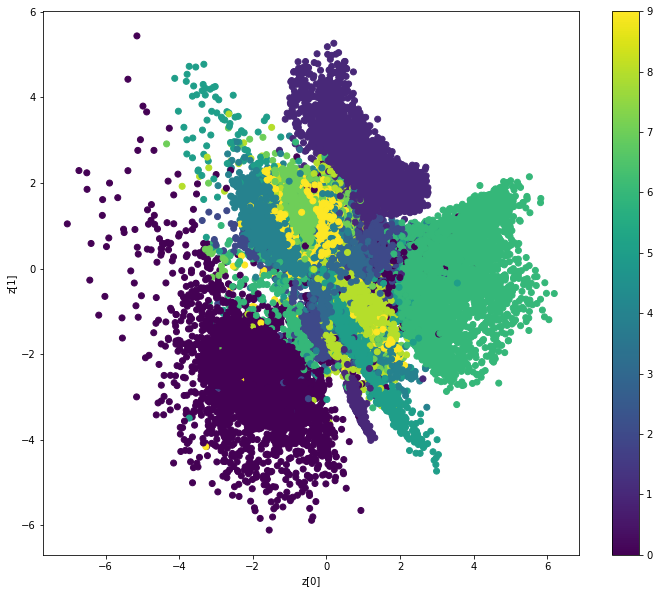

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

**Answer:** [TO COMPLETE}

From the obtained plot I can see that the model is able to reproduce all the digits, even though it has some trouble to separate some of them clearly. 

The model used before it's the best model I got and it's the baseline from where I started to explore what happen by changing some hyper-parameters.

**Model with less layers**

Reducing the number of layers, the model has a less capacity to detect better the most important features of the figures, creating an even more confused distribution.

Epoch 1/30
469/469 [==============================] - 2s 4ms/step - loss: 189.7392 - reconstruction_loss: 185.5525 - kl_loss: 4.1867
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 170.4121 - reconstruction_loss: 167.3717 - kl_loss: 3.0403
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 164.5430 - reconstruction_loss: 161.4401 - kl_loss: 3.1029
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 161.4828 - reconstruction_loss: 158.3405 - kl_loss: 3.1423
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 159.1138 - reconstruction_loss: 155.9097 - kl_loss: 3.2042
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 157.1735 - reconstruction_loss: 153.9004 - kl_loss: 3.2732
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 155.4649 - reconstruction_loss: 152.1389 - kl_loss: 3.3259
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - l

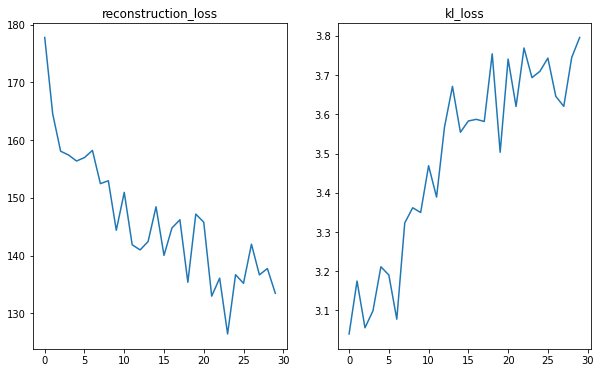

Current scale: 2.0


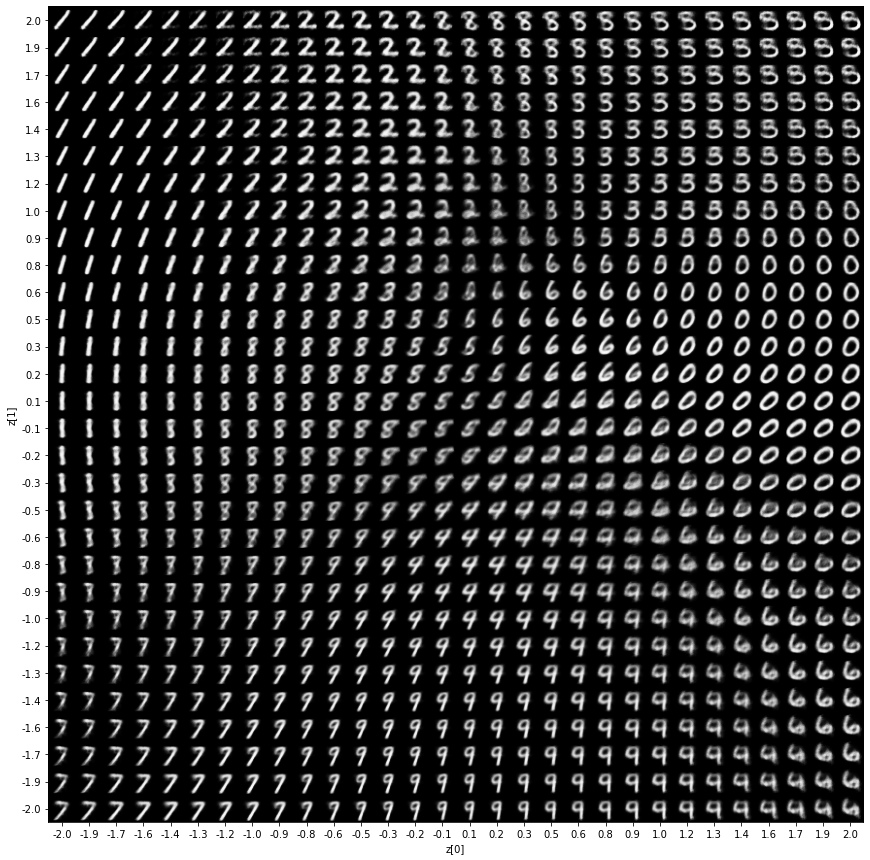

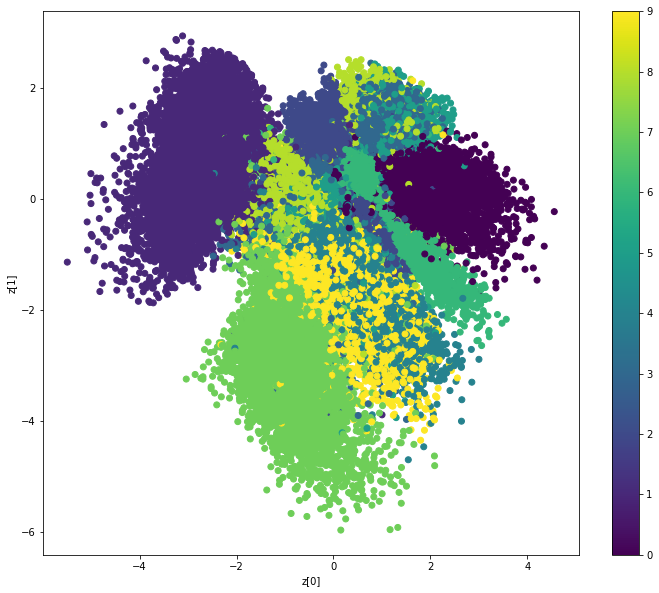

In [ ]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))
x = tf.keras.layers.Dense(512, activation='elu')(encoder_inputs)
x = tf.keras.layers.Dense(64, activation='elu')(x)


z_mean =  tf.keras.layers.Dense(latent_dim)(x)
z_var = tf.keras.layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x= tf.keras.layers.Dense(64,activation='elu')(latent_inputs)
x= tf.keras.layers.Dense(512,activation='elu')(x)
decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)

plot_loss(history)
plot_latent(encoder, decoder, 2.0, 30)
plot_label_clusters(encoder, decoder, x_train, y_train)

**Model with more layers**

Increasing the number of layers, the model is able to provide a distribution where some digits are more separated compared to the original one.

Epoch 1/30
469/469 [==============================] - 3s 5ms/step - loss: 182.6554 - reconstruction_loss: 179.7546 - kl_loss: 2.9008
Epoch 2/30
469/469 [==============================] - 2s 5ms/step - loss: 156.5071 - reconstruction_loss: 153.3311 - kl_loss: 3.1760
Epoch 3/30
469/469 [==============================] - 2s 5ms/step - loss: 150.2065 - reconstruction_loss: 146.8334 - kl_loss: 3.3731
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 146.9716 - reconstruction_loss: 143.5024 - kl_loss: 3.4692
Epoch 5/30
469/469 [==============================] - 2s 5ms/step - loss: 144.9223 - reconstruction_loss: 141.4059 - kl_loss: 3.5164
Epoch 6/30
469/469 [==============================] - 3s 6ms/step - loss: 143.1936 - reconstruction_loss: 139.5907 - kl_loss: 3.6029
Epoch 7/30
469/469 [==============================] - 2s 5ms/step - loss: 143.3488 - reconstruction_loss: 139.7270 - kl_loss: 3.6218
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - l

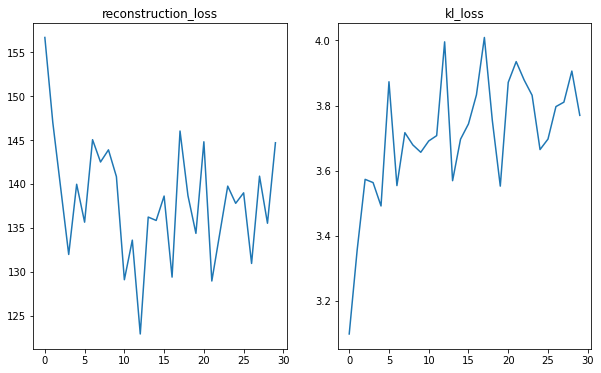

Current scale: 2.0


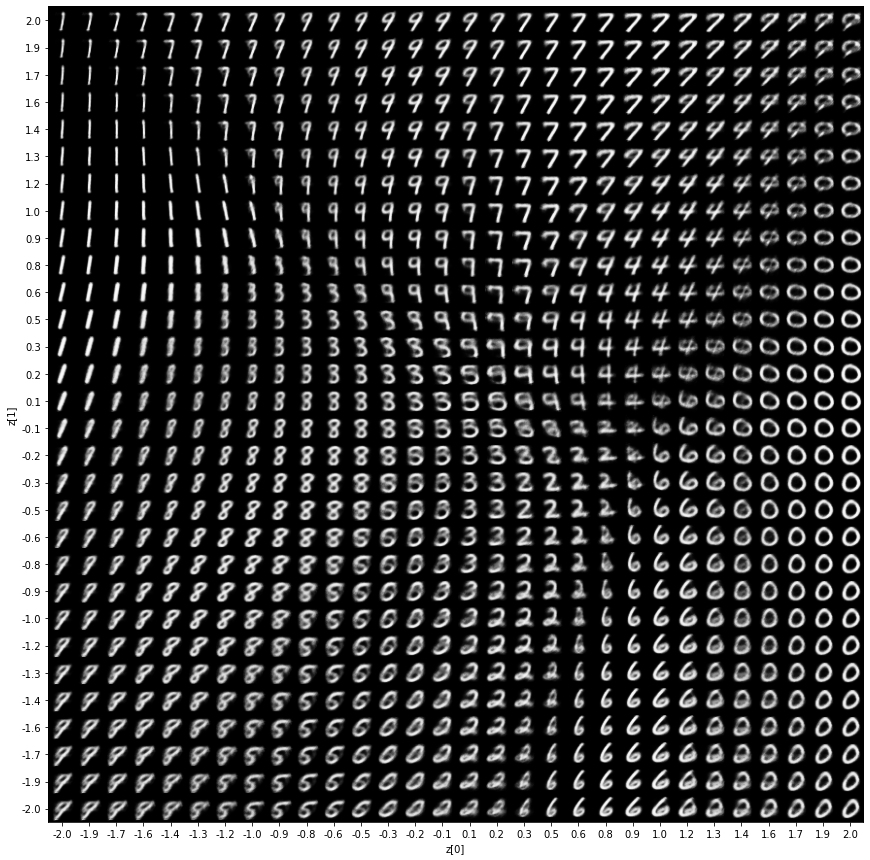

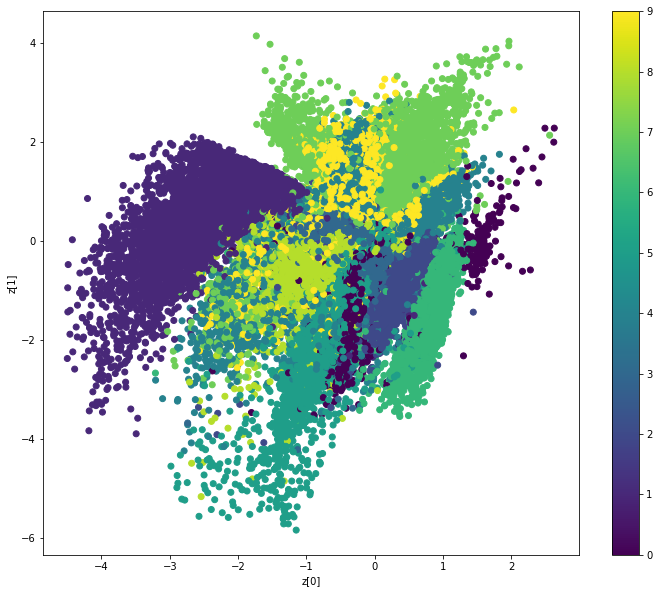

In [ ]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))
# x = ...[TO COMPLETE with more layers]...
x = tf.keras.layers.Dense(512, activation='elu')(encoder_inputs) #[TO COMPLETE]
x = tf.keras.layers.Dense(256, activation='elu')(x) #[TO COMPLETE]
x = tf.keras.layers.Dense(128, activation='elu')(x) #[TO COMPLETE]
x = tf.keras.layers.Dense(64, activation='elu')(x)
x = tf.keras.layers.Dense(32, activation='elu')(x)
x = tf.keras.layers.Dense(16, activation='elu')(x)


z_mean =  tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
#...[TO COMPLETE]...
x = tf.keras.layers.Dense(16, activation='elu')(latent_inputs)
x = tf.keras.layers.Dense(32, activation='elu')(x)
x= tf.keras.layers.Dense(64,activation='elu')(x)
x= tf.keras.layers.Dense(128,activation='elu')(x)
x= tf.keras.layers.Dense(256,activation='elu')(x)
x= tf.keras.layers.Dense(512,activation='elu')(x)
decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)

plot_loss(history)
plot_latent(encoder, decoder, 2.0, 30)
plot_label_clusters(encoder, decoder, x_train, y_train)

**Model with more parameters**

Increasing the number of units, that is raising the capacity of the model, we can see that the model gives a clearer separation of the digits.

Epoch 1/30
469/469 [==============================] - 4s 6ms/step - loss: 184.4551 - reconstruction_loss: 181.2487 - kl_loss: 3.2064
Epoch 2/30
469/469 [==============================] - 2s 5ms/step - loss: 159.3882 - reconstruction_loss: 156.1715 - kl_loss: 3.2168
Epoch 3/30
469/469 [==============================] - 2s 5ms/step - loss: 153.6007 - reconstruction_loss: 150.1578 - kl_loss: 3.4428
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 150.6144 - reconstruction_loss: 147.0481 - kl_loss: 3.5663
Epoch 5/30
469/469 [==============================] - 2s 5ms/step - loss: 148.5660 - reconstruction_loss: 144.9872 - kl_loss: 3.5788
Epoch 6/30
469/469 [==============================] - 2s 5ms/step - loss: 148.6596 - reconstruction_loss: 145.0062 - kl_loss: 3.6534
Epoch 7/30
469/469 [==============================] - 2s 5ms/step - loss: 145.4665 - reconstruction_loss: 141.7782 - kl_loss: 3.6882
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - l

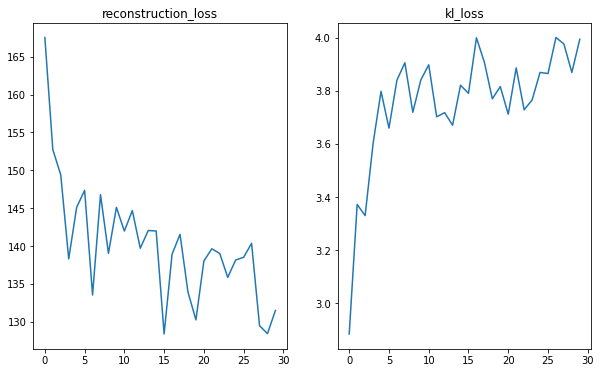

Current scale: 2.0


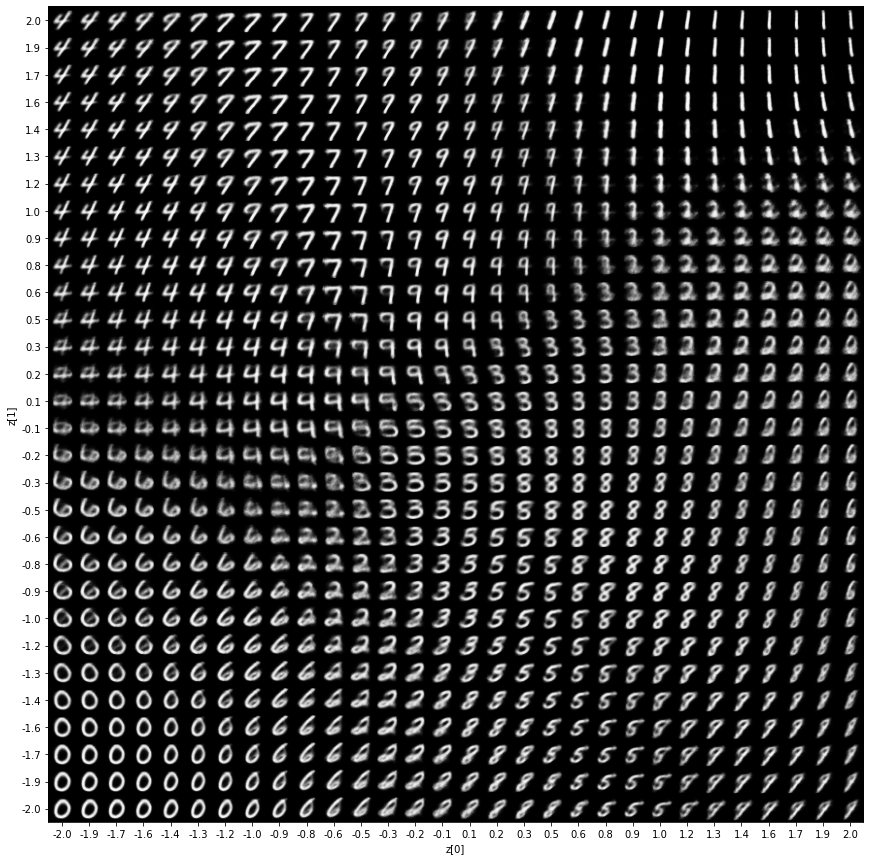

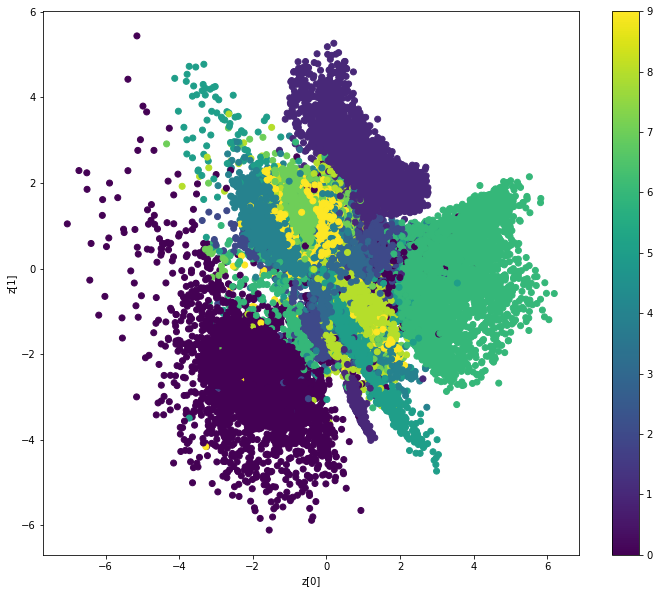

In [ ]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))
# x = ...[TO COMPLETE with more layers]...
x = tf.keras.layers.Dense(720, activation='elu')(encoder_inputs) #[TO COMPLETE]
x = tf.keras.layers.Dense(360, activation='elu')(x) #[TO COMPLETE]
x = tf.keras.layers.Dense(180, activation='elu')(x)
x = tf.keras.layers.Dense(90, activation='elu')(x)
x = tf.keras.layers.Dense(45, activation='elu')(x)


z_mean =  tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
#...[TO COMPLETE]...
x = tf.keras.layers.Dense(45, activation='elu')(latent_inputs)
x= tf.keras.layers.Dense(90,activation='elu')(x)
x= tf.keras.layers.Dense(180,activation='elu')(x)
x= tf.keras.layers.Dense(360,activation='elu')(x)
x= tf.keras.layers.Dense(720,activation='elu')(x)
decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)

plot_loss(history)
plot_latent(encoder, decoder, 2.0, 30)
plot_label_clusters(encoder, decoder, x_train, y_train)

**Model with less parameters**

Decreasing the number of units, that is reducing the capacity of the model, we can see that the model gives a more blurred version of the original digits.

Epoch 1/30
469/469 [==============================] - 3s 5ms/step - loss: 186.8359 - reconstruction_loss: 183.8733 - kl_loss: 2.9626
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 162.3535 - reconstruction_loss: 159.3798 - kl_loss: 2.9737
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 154.4814 - reconstruction_loss: 151.3418 - kl_loss: 3.1396
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 148.5901 - reconstruction_loss: 145.2317 - kl_loss: 3.3584
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 145.4791 - reconstruction_loss: 142.0081 - kl_loss: 3.4710
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 143.1916 - reconstruction_loss: 139.6566 - kl_loss: 3.5350
Epoch 7/30
469/469 [==============================] - 2s 5ms/step - loss: 142.1461 - reconstruction_loss: 138.5738 - kl_loss: 3.5723
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - l

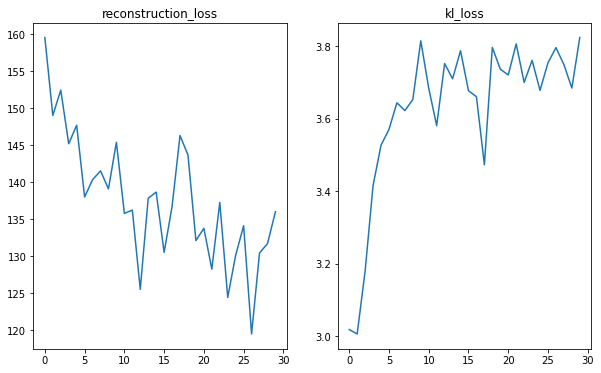

Current scale: 2.0


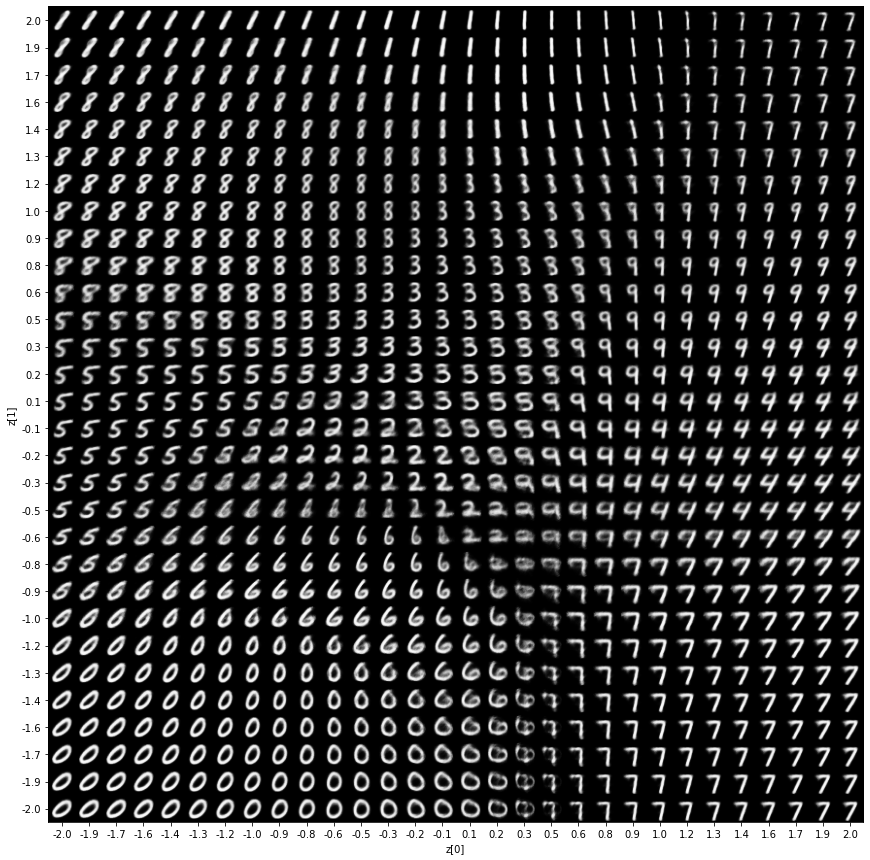

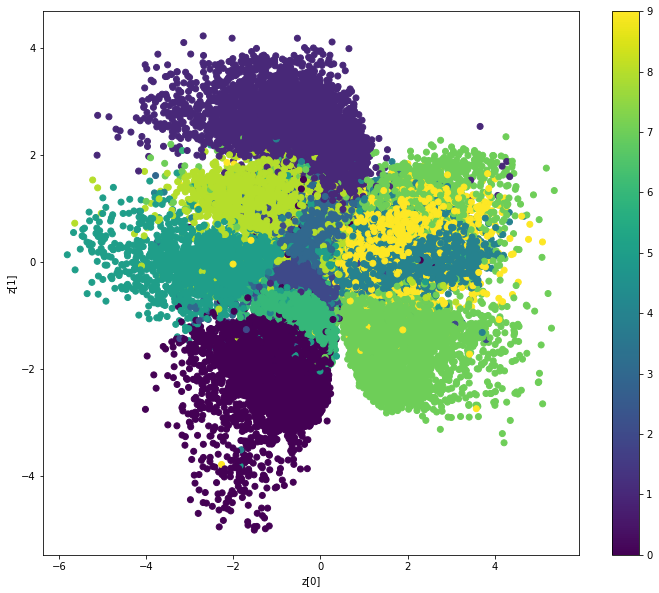

In [ ]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))
# x = ...[TO COMPLETE with more layers]...
x = tf.keras.layers.Dense(320, activation='elu')(encoder_inputs) #[TO COMPLETE]
x = tf.keras.layers.Dense(220, activation='elu')(x) #[TO COMPLETE]
x = tf.keras.layers.Dense(120, activation='elu')(x)
x = tf.keras.layers.Dense(64, activation='elu')(x)
x = tf.keras.layers.Dense(32, activation='elu')(x)


z_mean =  tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
#...[TO COMPLETE]...
x = tf.keras.layers.Dense(32, activation='elu')(latent_inputs)
x= tf.keras.layers.Dense(64,activation='elu')(x)
x= tf.keras.layers.Dense(120,activation='elu')(x)
x= tf.keras.layers.Dense(220,activation='elu')(x)
x= tf.keras.layers.Dense(320,activation='elu')(x)
decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)

plot_loss(history)
plot_latent(encoder, decoder, 2.0, 30)
plot_label_clusters(encoder, decoder, x_train, y_train)